# How could COVID-19 be detected in X-ray images?


COVID-19 tests are currently hard to come by — there are simply not enough of them and they cannot be manufactured fast enough, which is causing panic.

When there’s panic, there are nefarious people looking to take advantage of others, namely by selling fake COVID-19 test kits after finding victims on social media platforms and chat applications.

Given that there are limited COVID-19 testing kits, we need to rely on other diagnosis measures.

For the purposes of this tutorial, I thought to explore X-ray images as doctors frequently use X-rays and CT scans to diagnose pneumonia, lung inflammation, abscesses, and/or enlarged lymph nodes.

Since COVID-19 attacks the epithelial cells that line our respiratory tract, we can use X-rays to analyze the health of a patient’s lungs.

And given that nearly all hospitals have X-ray imaging machines, it could be possible to use X-rays to test for COVID-19 without the dedicated test kits.

A drawback is that X-ray analysis requires a radiology expert and takes significant time — which is precious when people are sick around the world. Therefore developing an automated analysis system is required to save medical professionals valuable time.

## Our COVID-19 patient X-ray image dataset

CoronaVirus (COVID-19) chest X-ray image data. On the left we have positive (i.e., infected) X-ray images, whereas on the right we have negative samples. These images are used to train a deep learning model with TensorFlow and Keras to automatically predict whether a patient has COVID-19 (i.e., coronavirus).


In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.pyimagesearch.com/wp-content/uploads/2020/03/covid19_keras_dataset.png")


The COVID-19 X-ray image dataset we’ll be using for this tutorial was curated by Dr. Joseph Cohen, a postdoctoral fellow at the University of Montreal.

One week ago, Dr. Cohen started collecting X-ray images of COVID-19 cases and publishing them in the [following GitHub repo](https://github.com/ieee8023/covid-chestxray-dataset).

Inside the repo you’ll find example of COVID-19 cases, as well as MERS, SARS, and ARDS.

In order to create the COVID-19 X-ray image dataset, we:

1. Parsed the metadata.csv file found in Dr. Cohen’s repository.
2. Selected all rows that are:
   1. Positive for COVID-19 (i.e., ignoring MERS, SARS, and ARDS cases).
   2. Posterioranterior (PA) view of the lungs. I used the PA view as, to my knowledge, that was the view used for my “healthy” cases, as discussed below; however, I’m sure that a medical professional will be able clarify and correct me if I am incorrect (which I very well may be, this is just an example).
   
In total, that left us with 25 X-ray images of positive COVID-19 cases(Figure 2, left).

The next step was to sample X-ray images of healthy patients.

To do so, we used Kaggle’s Chest X-Ray Images (Pneumonia) dataset and sampled 25 X-ray images from healthy patients (Figure 2, right). There are a number of problems with Kaggle’s Chest X-Ray dataset, namely noisy/incorrect labels, but it served as a good enough starting point for this proof of concept COVID-19 detector.

**After gathering my dataset, we were left with 50 total images, equally split with 25 images of COVID-19 positive X-rays and 25 images of healthy patient X-rays.**

## Implementing our COVID-19 training script using Keras and TensorFlow

### Import Libraries

In [1]:
# USAGE
# python train.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

### Load and Preprcessing Data

Load the image, and preprocess it by converting to RGB channel ordering, and resizing it to 224×224 pixels so that it is ready for our Convolutional Neural Network

In [2]:
args = {"dataset":'./dataset/'}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


### Create Data Generator to feed data to Deep Learning Model

Construct our data split, reserving 80% of the data for training and 20% for testing.

In order to ensure that our model generalizes, we perform data augmentation by setting the random image rotation setting to 15 degrees clockwise or counterclockwise.

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

### Build Deep Learning CNN Model

Instantiate the VGG16 network with weights pre-trained on ImageNet, leaving off the FC layer head.

From there, we construct a new fully-connected layer head consisting of POOL => FC = SOFTMAX layers (Lines 88-93) and append it on top of VGG16 (Line 97).

We then freeze the CONV weights of VGG16 such that only the FC layer head will be trained (Lines 101-102); this completes our fine-tuning setup.

We’re now ready to compile and train our COVID-19 (coronavirus) deep learning model:

In [9]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False



[INFO] compiling model...


### Compile and Train the CNN Model

Compile the network with learning rate decay and the Adam optimizer. Given that this is a 2-class problem, we use "binary_crossentropy" loss rather than categorical crossentropy.

To kick off our COVID-19 neural network training process, we make a call to Keras’ fit_generator method, while passing in our chest X-ray data via our data augmentation object

In [11]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 6s 1s/step - loss: 0.8263 - accuracy: 0.5000 - val_loss: 0.5567 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 5s 1s/step - loss: 0.8641 - accuracy: 0.4250 - val_loss: 0.5343 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 5s 1s/step - loss: 0.6674 - accuracy: 0.5250 - val_loss: 0.5053 - val_accuracy: 0.6250
Epoch 4/25
5/5 [==============================] - 5s 1s/step - loss: 0.8078 - accuracy: 0.4750 - val_loss: 0.5002 - val_accuracy: 0.6250
Epoch 5/25
5/5 [==============================] - 5s 1000ms/step - loss: 0.6390 - accuracy: 0.6500 - val_loss: 0.4744 - val_accuracy: 0.6250
Epoch 6/25
5/5 [==============================] - 5s 972ms/step - loss: 0.5615 - accuracy: 0.7250 - val_loss: 0.4434 - val_accuracy: 0.8750
Epoch 7/25
5/5 [==============================] - 5s 1

### Evaluate the model

In [12]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      0.80      0.89         5
      normal       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



### Confusion Matrix on Prediction Accuracy

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

### Plot training accuracy/loss history

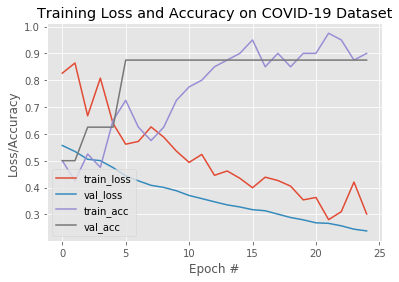

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])

### Save CNN Model

In [15]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
# model.save(args["model"], save_format="h5")

[INFO] saving COVID-19 detector model...


## Credits

[Adrian Rosebrock, Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/#download-the-code)